In [127]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, masking
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import expression_to_contrast_vector
from nilearn import plotting
from glob import glob
from pyrelimri import similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
def nifti_tstat_to_cohensd(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    
    if not os.path.exists(d_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate Cohen's d using the t_stat / sqrt(n) formula
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(t_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)

def create_hitmiss(events_df: pd.DataFrame, hit_col: str, condition_col: str) -> pd.DataFrame:

    # create a delinated hit v miss column so it is more clear
    feedback_hitmiss_lab = 'Feedback.Response'
    events_df[feedback_hitmiss_lab] = np.where(events_df[hit_col] == 1.0,
                                               events_df[condition_col] + '_hit',
                                               events_df[condition_col] + '_miss')
    return events_df

def calc_mask_avg(img, mask):
    masked_data = masking.apply_mask(image.load_img(img), mask)
    return np.round(np.mean(masked_data), 3)

# set paths for RT and group maps calcs

In [142]:
session = 'ses-2YearFollowUpYArm1'
out_path = '/scratch.global/mdemiden/mid_rt_mod'
grpmap_path = f'{out_path}/group/{session}/session'
fix_path = f'{out_path}/firstlvl/{session}'
beh_path = '/home/feczk001/mdemiden/slurm_ABCD_s3/Beh_Data/events_to_tsv/2YearFollowUpYArm1_MID'
script_path='/home/feczk001/mdemiden/analyses/mid_rt_bold/scripts'
sub_list = f'{script_path}/cluster_jobs/subject_ids/ids_sub_2yr.tsv'
left_nac = f'{script_path}/brain_mask/Left_NAcc.nii.gz'
right_nac = f'{script_path}/brain_mask/Right_NAcc.nii.gz'

# Convert t-maps to d-maps

In [ ]:
t_list = glob(os.path.join(grpmap_path,"subs-500_*_stat-tstat_*.nii.gz"))
for t_path in t_list:
    nifti_tstat_to_cohensd(tstat_path=t_path, n=500)

# Calculate RT values to use in Group maps

Calculate RT values for each subjects (average across runs within each subject).

Taking mean OverallRT within run per subject and then average the two for each subject for a single value per session.

In [58]:
out_rts = []

sub_df = pd.read_csv(sub_list, sep='\t',header=None)
for sub in sub_df[0]:    
    run1 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv'
    run1_df = pd.read_csv(run1, sep='\t')
    avg_rt1 = round(run1_df['OverallRT'].mean(),3)
    
    run2 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv'
    run2_df = pd.read_csv(run2, sep='\t')
    avg_rt2 = round(run2_df['OverallRT'].mean(),3)

    avg_rts = round(np.mean([avg_rt1,avg_rt2]),3)
    out_rts.append({'Subject': sub, 'Average_RT': avg_rts})
    
out_rts_df = pd.DataFrame(out_rts)
out_rts_df.to_csv(f'{out_path}/subs_avg-overall-rts.csv', index=False)

# Run Avg Betas + Conditional RTs

In [156]:
fb_contrasts = {
    'ARewHit-ARewMiss': ['LgReward_hit','SmallReward_hit','LgReward_miss','SmallReward_miss'],
    'LRewHit-LRewMiss': ['LgReward_hit','LgReward_miss'], 
    'APunHit-APunMiss': ['LgPun_hit','SmallPun_hit','LgPun_miss','SmallPun_miss'],
    'LPunHit-LPunMiss': ['LgPun_hit','LgPun_miss'], 
    'LRewHit-NeutHit': ['LgReward_hit', 'Triangle_hit']
}

In [ ]:
sub_ids = []
label_list = []
left_rt_mod_list = []
right_rt_mod_list = []
left_non_rt_list = []
right_non_rt_list = []
r1_avg_a_list = []
r2_avg_a_list = []
r1_avg_b_list = []
r2_avg_b_list = []

sub_df = pd.read_csv(sub_list, sep='\t',header=None)

for sub in sub_df[0]:
    # create hit/miss feedback consistent with first lvl models
    r1_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-01_events.tsv', sep='\t')
    r2_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-02_events.tsv', sep='\t')
    r1_df = create_hitmiss(r1_df, 'prbacc','Condition')
    r2_df = create_hitmiss(r2_df, 'prbacc','Condition')

    # iterate over contrsat label + Feedback.Response elements to calcualte RTs & extra run avg beta weights 
    for label, contrast  in fb_contrasts.items():
        cue_rt_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-rt_stat-effect.nii.gz'
        cue_none_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-None_stat-effect.nii.gz'
        rtmod_leftnac = calc_mask_avg(cue_rt_img, left_nac)
        rtmod_rightnac = calc_mask_avg(cue_rt_img, right_nac)
        nort_leftnac = calc_mask_avg(cue_none_img, left_nac)
        nort_rightnac = calc_mask_avg(cue_none_img, right_nac)

        # constrain Feedback cues to elements used in contrast
        filt_r1 = r1_df[r1_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])
        filt_r2 = r2_df[r2_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])

        # Lg+small hit + Lg + small miss = four elements, otherwise feedback has 2 elements (e.g. lg hit > lg miss)
        if len(contrast) > 2:
            # hit mRTs 
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            # miss mRTs
            r1_avg_b = filt_r1[filt_r1['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            
        elif len(contrast) <= 2:
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'] == a[0]]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'] == a[0]]['OverallRT'].mean()

            r1_avg_b = filt_r1[filt_r1['Feedback.Response'] == a[1]]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'] == a[1]]['OverallRT'].mean()

        # Append to lists
        sub_ids.append(sub)
        label_list.append(label)
        left_rt_mod_list.append(rtmod_leftnac)
        right_rt_mod_list.append(rtmod_rightnac)
        left_non_rt_list.append(nort_leftnac)
        right_non_rt_list.append(nort_rightnac)
        r1_avg_a_list.append(r1_avg_a)
        r2_avg_a_list.append(r2_avg_a)
        r1_avg_b_list.append(r1_avg_b)
        r2_avg_b_list.append(r2_avg_b)

In [ ]:
comb_vars = {
    'sub': sub_ids,
    'contrast': label_list,
    'left_rt_mod': left_rt_mod_list,
    'right_rt_mod': right_rt_mod_list,
    'left_none_rt': left_non_rt_list,
    'right_none_rt': right_non_rt_list,
    'r1_avg_a': r1_avg_a_list,
    'r2_avg_a': r2_avg_a_list,
    'r1_avg_b': r1_avg_b_list,
    'r2_avg_b': r2_avg_b_list
}

betas_rts_df = pd.DataFrame(comb_vars)
betas_rts_df

# Making plots for group maps

In [155]:
# group level contrast estimates
contrasts_reg = [
    # anticipatory contrasts for cue-model
    'LRew-Neut', 'ARew-Neut', 'LPun-Neut', 'APun-Neut',
    # feedback contrasts
    'ARewHit-ARewMiss', 'LRewHit-LRewMiss', 'APunHit-APunMiss',
    'LPunHit-LPunMiss', 'LRewHit-NeutHit'
]

# rt versus non-rt model
models = ['Cue-rt', 'Cue-None']

# thresh/coordinate
spec_coords = (12,8,-10)
d_thresh = .2
d_max =1

## Group Map Cons - Intercept [1 0]

In [8]:
intercept_imgs = glob(f'{grpmap_path}/subs-500_*_stat-tstat_int.nii.gz')

In [13]:
int_pairwise = similarity.pairwise_similarity(nii_filelist=intercept_imgs, mask = None, similarity_type = 'spearman')

In [14]:
int_pairwise['similar_coef_r'] = pd.to_numeric(int_pairwise['similar_coef']).round(3)
int_pairwise[['img1','img2']] = int_pairwise['image_labels'].str.split('~', expand=True)
int_pairwise['img1_short'] = int_pairwise['img1'].str.split('_').apply(lambda x: x[3:5]).apply(lambda x: '_'.join(x))
int_pairwise['img2_short'] = int_pairwise['img2'].str.split('_').apply(lambda x: x[3:5]).apply(lambda x: '_'.join(x))

In [15]:
int_pairwise

,similar_coef,image_labels,similar_coef_r,img1,img2,img1_short,img2_short
0,0.9989504711126432,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.999,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-APun-Neut_mod-Cue-None,contrast-APun-Neut_mod-Cue-rt
1,0.033731375714299884,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.034,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-APun-Neut_mod-Cue-None,contrast-APunHit-APunMiss_mod-Cue-None
2,-0.09486990228799101,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,-0.095,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-APun-Neut_mod-Cue-None,contrast-APunHit-APunMiss_mod-Cue-rt
3,0.8932969731117245,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.893,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-APun-Neut_mod-Cue-None,contrast-ARew-Neut_mod-Cue-None
4,0.8937755052729193,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.894,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-APun-Neut_mod-Cue-None,contrast-ARew-Neut_mod-Cue-rt
...,...,...,...,...,...,...,...
185,-0.4760323341555062,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,-0.476,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-LRewHit-LRewMiss_mod-Cue-None,contrast-probe-base_mod-Cue-rt
186,0.15795893590324653,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.158,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-LRewHit-LRewMiss_mod-Cue-None,contrast-rt-base_mod-Cue-rt
187,-0.6717357955613334,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,-0.672,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-LRewHit-LRewMiss_mod-Cue-rt,contrast-probe-base_mod-Cue-rt
188,0.12468071124000514,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,0.125,subs-500_ses-2YearFollowUpYArm1_task-MID_contr...,subs-500_ses-2YearFollowUpYArm1_task-MID_cont...,contrast-LRewHit-LRewMiss_mod-Cue-rt,contrast-rt-base_mod-Cue-rt


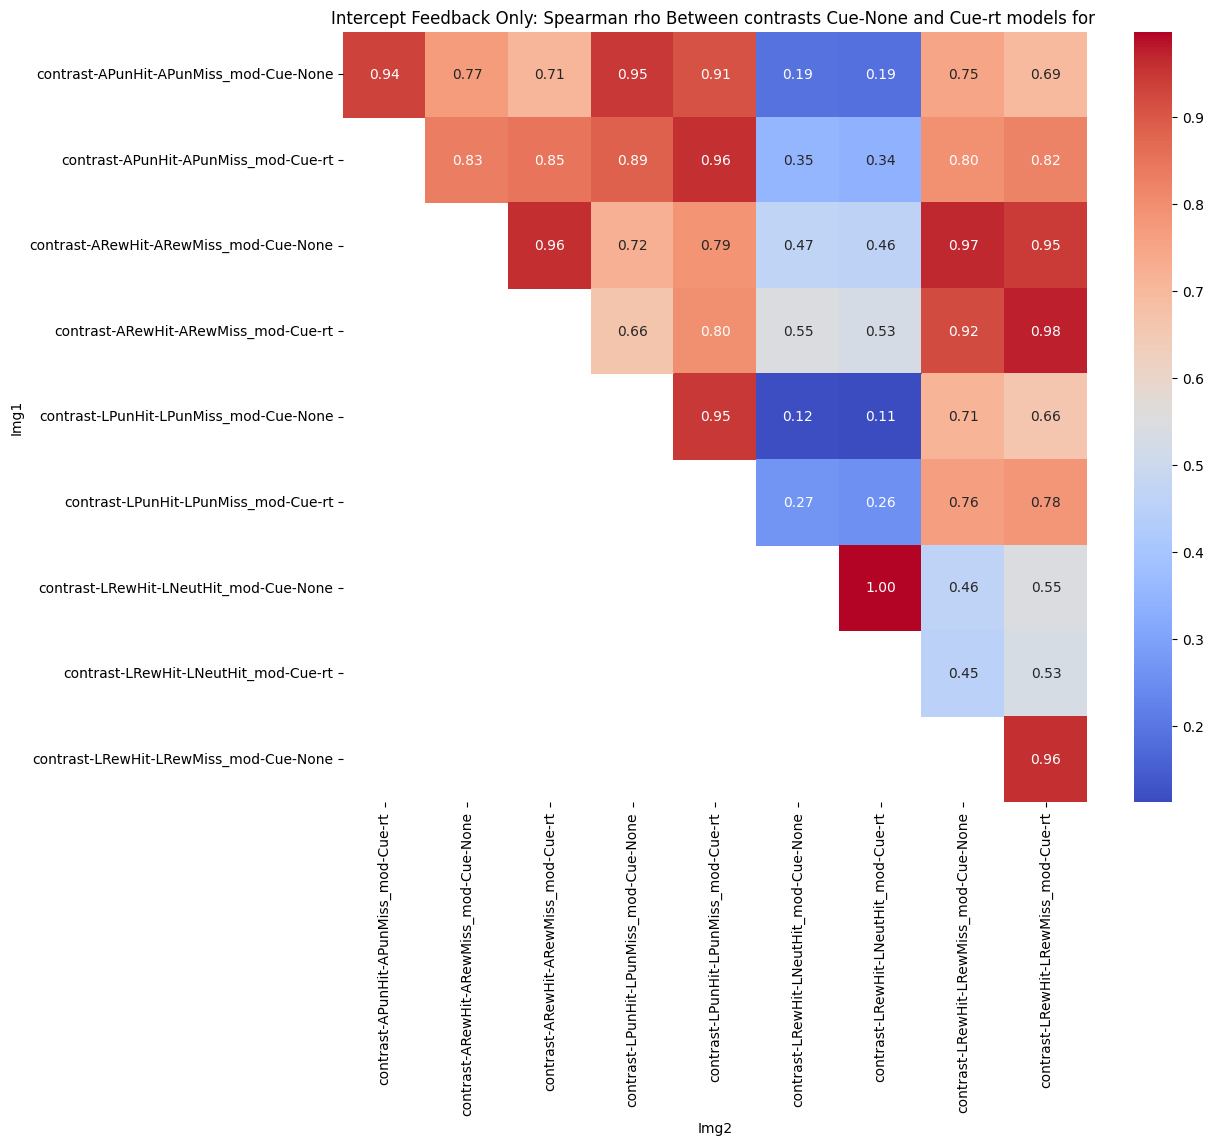

In [16]:
filtered_feedback = int_pairwise[(int_pairwise['img1_short'].str.contains('Hit|Miss')) & (int_pairwise['img2_short'].str.contains('Hit|Miss'))]

# Create correlation matrix from the filtered DataFrame
fb_matrix = filtered_feedback.pivot(index='img1_short', columns='img2_short', values='similar_coef_r')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(fb_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title('Intercept Feedback Only: Spearman rho Between contrasts Cue-None and Cue-rt models for ')
plt.xlabel('Img2')
plt.ylabel('Img1')
plt.show()

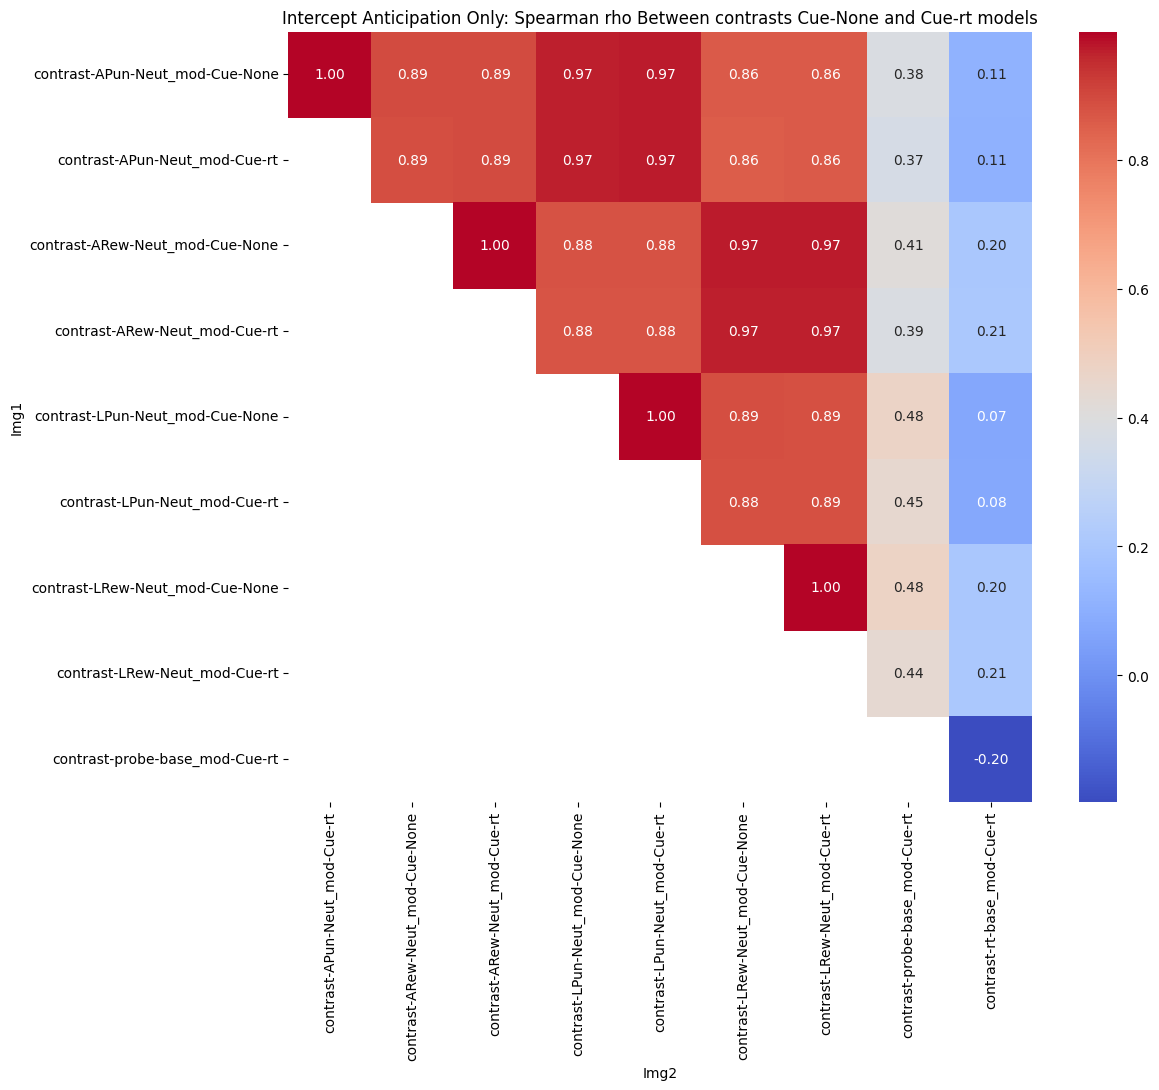

In [17]:
filtered_ant = int_pairwise[~((int_pairwise['img1_short'].str.contains('Hit|Miss')) | (int_pairwise['img2_short'].str.contains('Hit|Miss')))]

# Create correlation matrix from the filtered DataFrame
ant_matrix = filtered_ant.pivot(index='img1_short', columns='img2_short', values='similar_coef_r')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ant_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title('Intercept Anticipation Only: Spearman rho Between contrasts Cue-None and Cue-rt models')
plt.xlabel('Img2')
plt.ylabel('Img1')
plt.show()

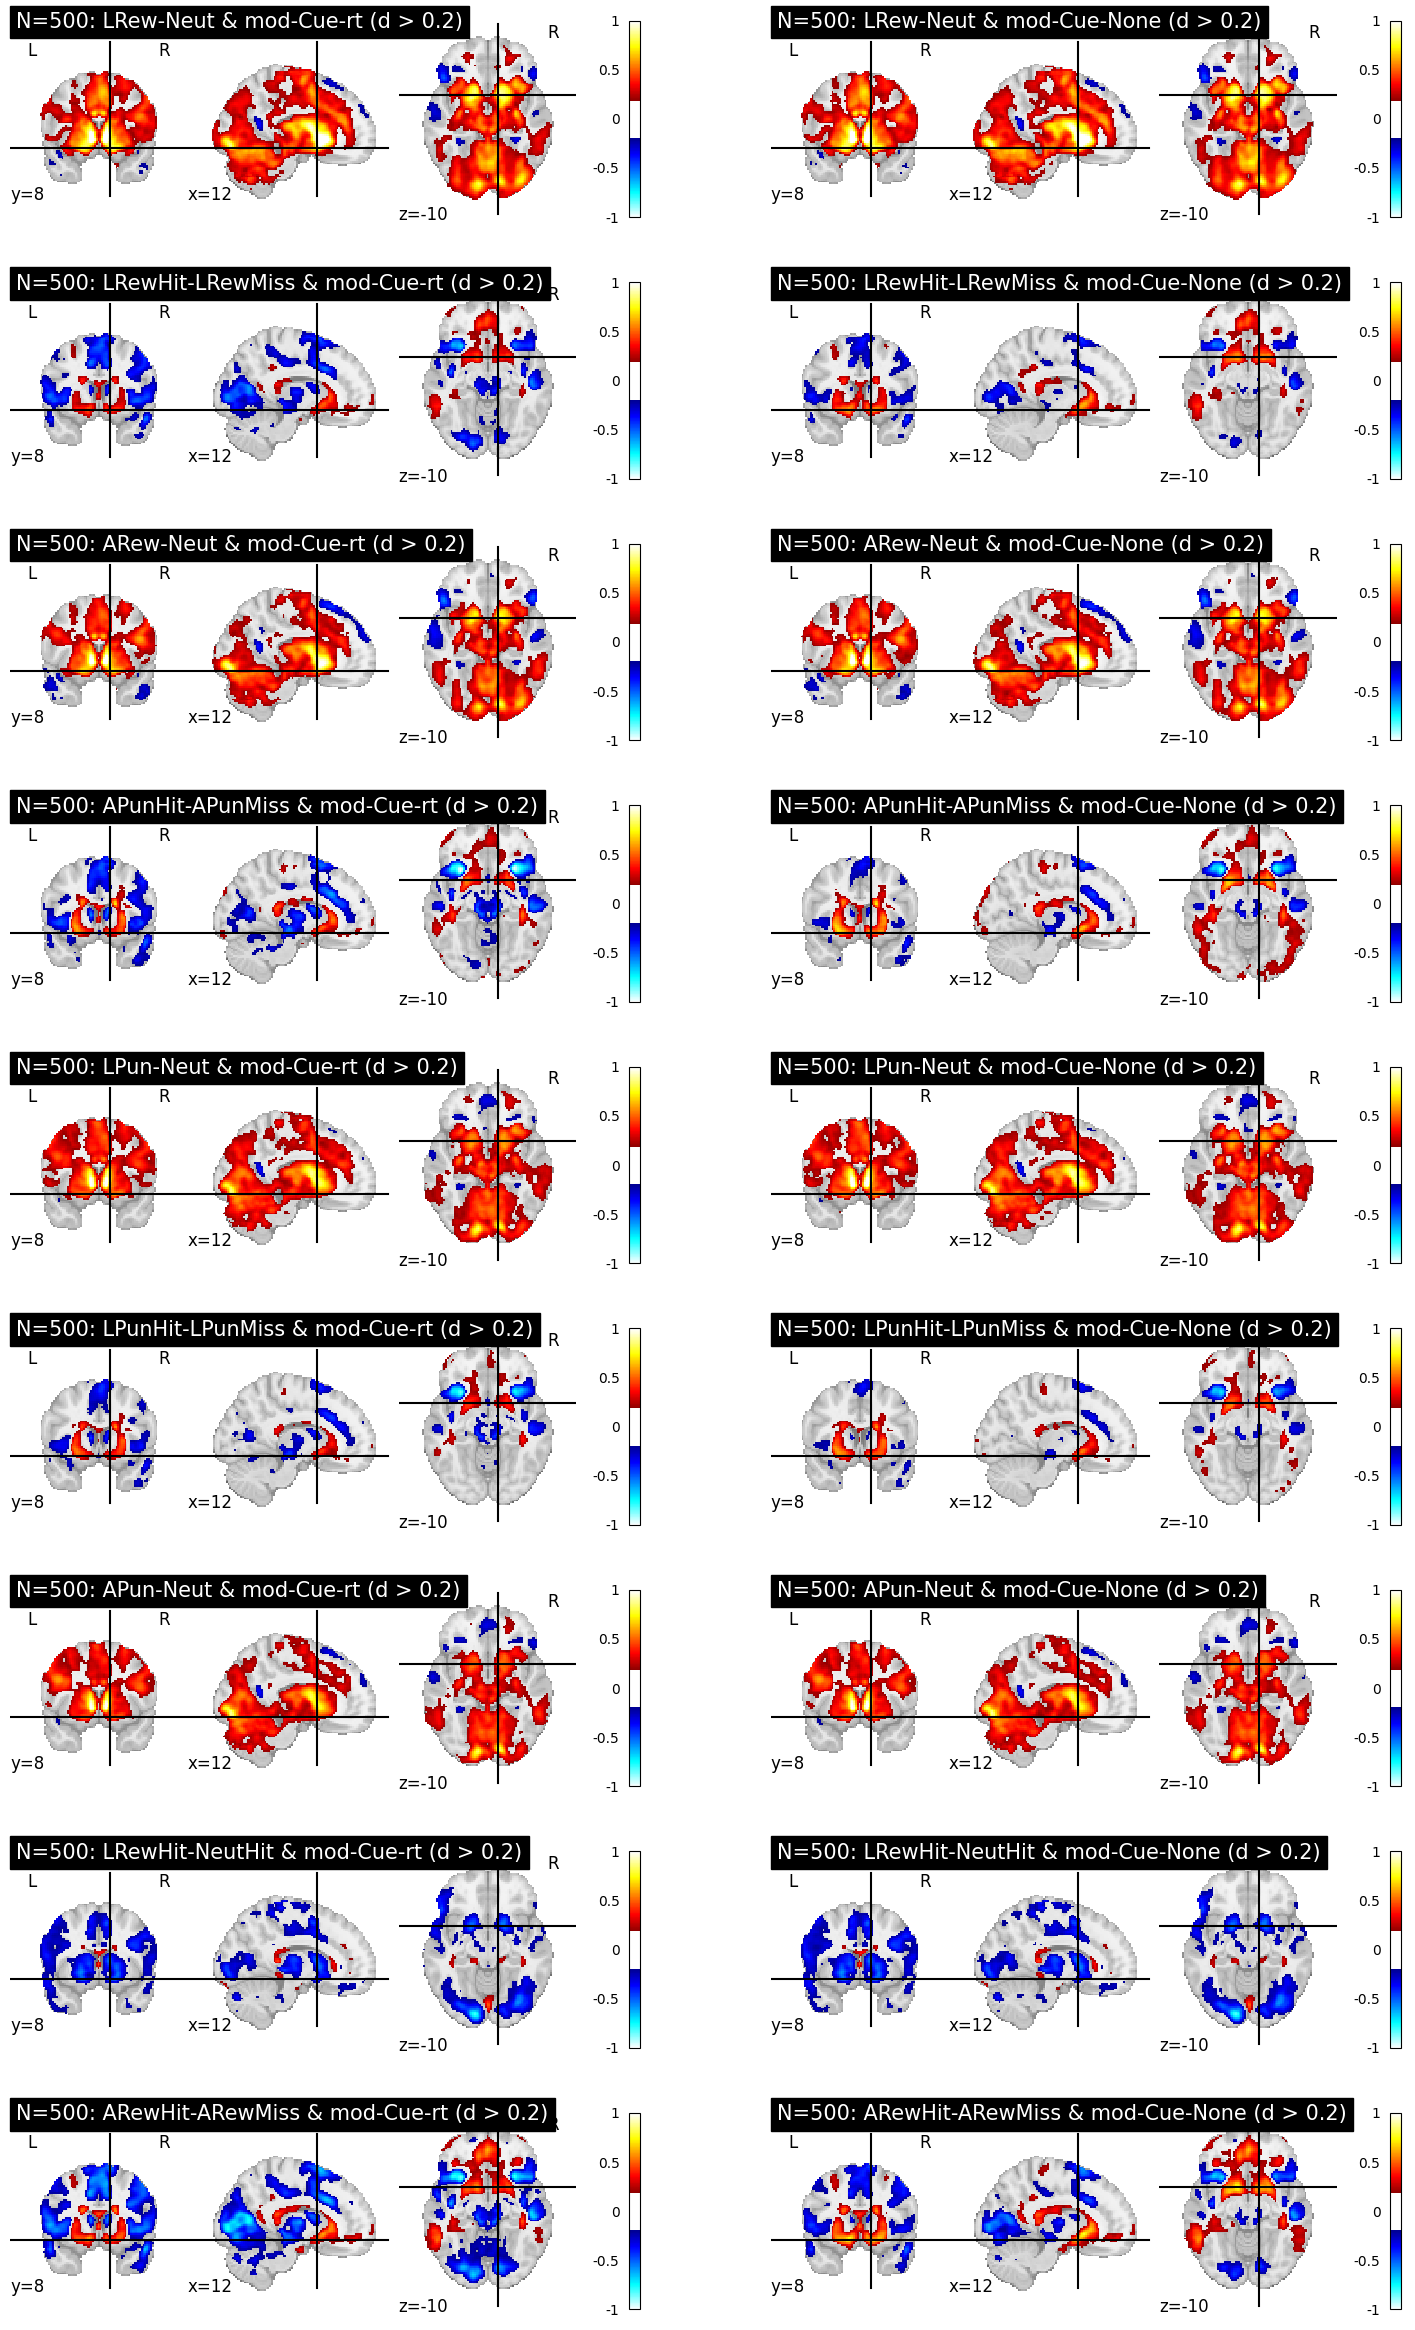

In [157]:
n_cols = 2
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None']:
    for i, con in enumerate(contrasts_reg):
        con_img = glob(f'{grpmap_path}/subs-500_*{con}_{mod}_stat-cohensd_int.nii.gz')[0]
        row = (i * 2) % n_rows  # Ensure row stays within the range of n_rows
        col = ['mod-Cue-rt', 'mod-Cue-None'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"N=500: {con} & {mod} (d > {d_thresh})", threshold=d_thresh, draw_cross=True,
                               vmax=d_max, colorbar=True,
                               axes=axes[row, col])

plt.show()

differences between  `mod-Cue-None` - `mod-Cue-rt`

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


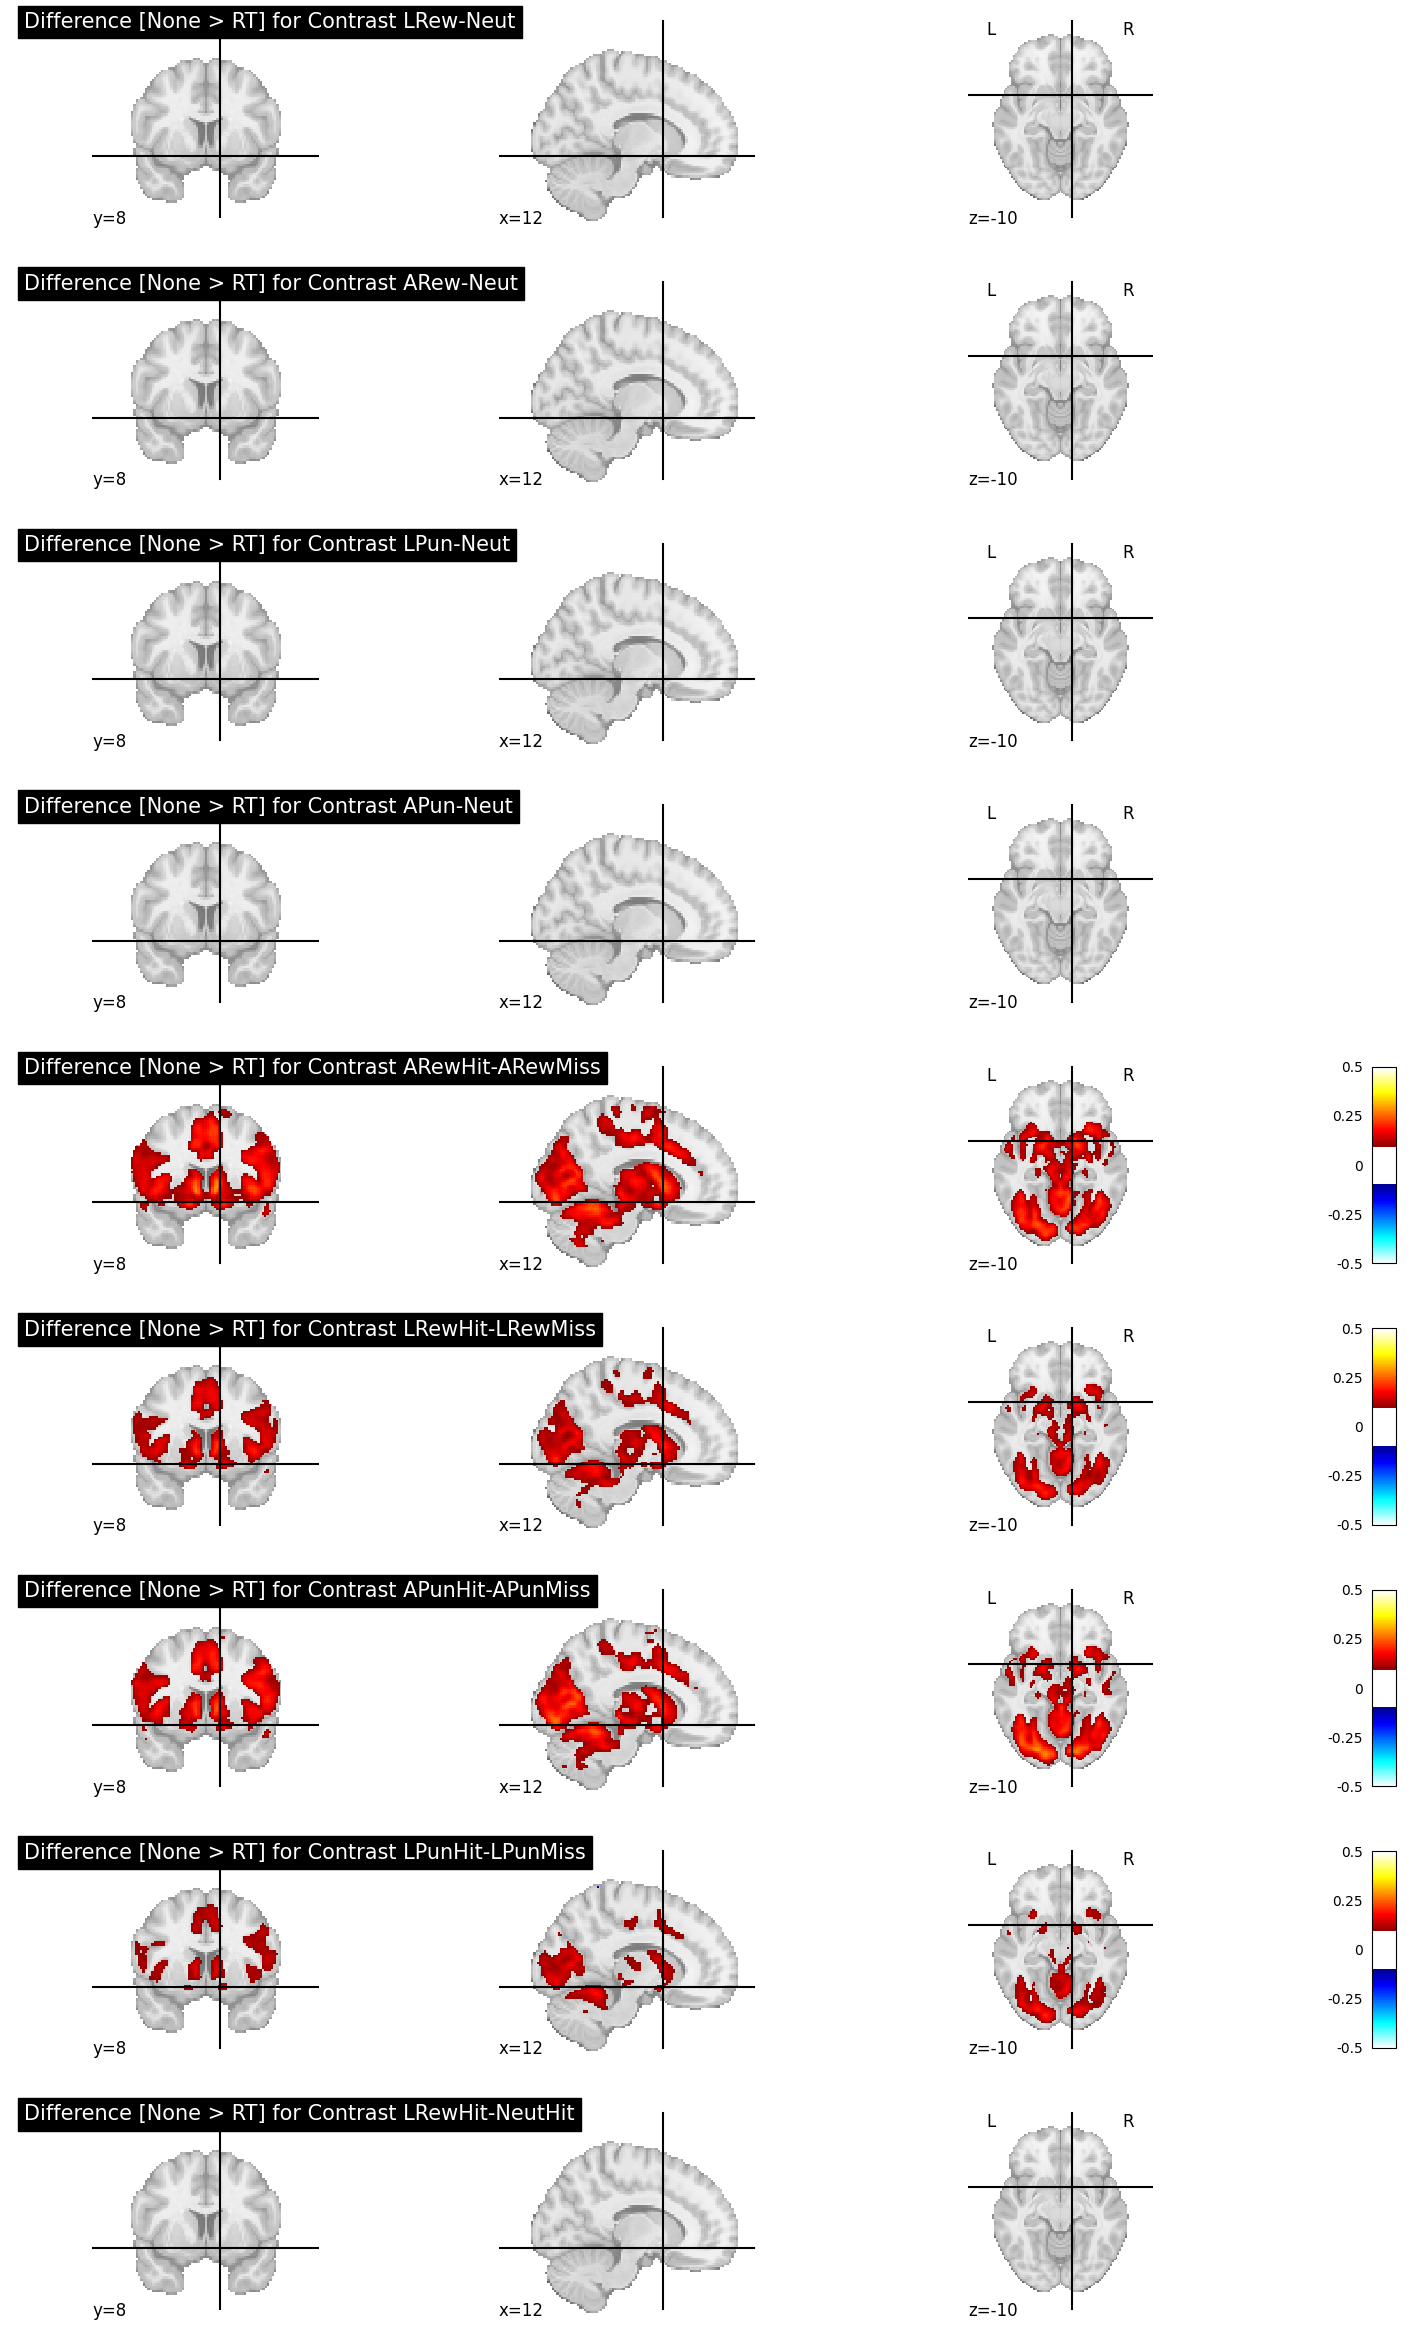

In [158]:
rt_minus_none = []
for i, con in enumerate(contrasts_reg):
    con_img_rt = nib.load(glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-rt_stat-cohensd_int.nii.gz')[0])
    con_img_none = nib.load(glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-None_stat-cohensd_int.nii.gz')[0])
    
    # get data, compute diff and convert back to nifti w/ original affine
    con_data_rt = con_img_rt.get_fdata()
    con_data_none = con_img_none.get_fdata()
    difference =  con_data_none - con_data_rt
    
    # Create a new NIfTI image from the differences
    diff_img = nib.Nifti1Image(difference, con_img_rt.affine)
    
    # Append the difference image to the list
    rt_minus_none.append((diff_img, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"Difference [None > RT] for Contrast {con}", threshold=.1, draw_cross=True,
                           vmax=.5, colorbar=True,
                           axes=axes[i])

plt.show()

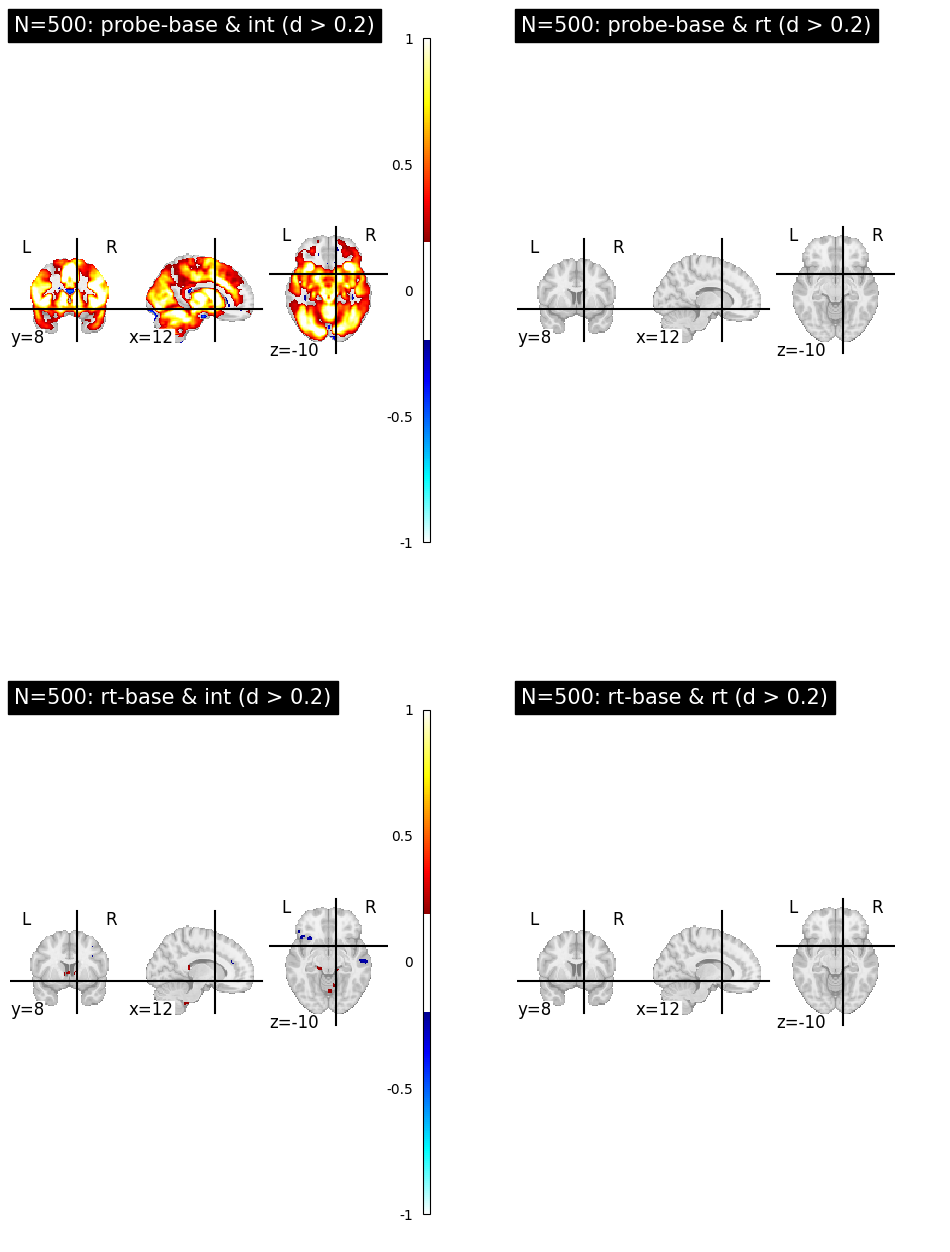

In [159]:
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))

for i, con in enumerate(['probe-base', 'rt-base']):
    for j, val in enumerate(['int', 'rt']):
        con_img = glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-rt_stat-cohensd_{val}.nii.gz')[0]
        row = i  # Use i as row index
        col = j  # Use j as column index
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,
                               display_mode="ortho",
                               title=f"N=500: {con} & {val} (d > {d_thresh})", threshold=d_thresh, draw_cross=True,
                               vmax=d_max, colorbar=True,
                               axes=axes[row, col])

plt.show()

# Below is example to set up design matrix

Set paths and load the behavioral data for n = 1

In [2]:
dir_in = '/Users/michaeldemidenko/Downloads/2YearFollowUpYArm1_MID'
dir_out = '/Users/michaeldemidenko/Downloads'
beh_n1 = glob(f'{dir_in}/*_task-MID_run-01_events.tsv')[0]

In [3]:
events_df = pd.read_csv(beh_n1,sep='\t')
events_df.columns

Index(['Subject', 'Handedness', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Anticipation.Duration',
       'Anticipation.OnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.RESP', 'Result', 'prbacc', 'prbrt', 'OverallRT', 'meanrt',
       'moneyamt', 'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'SessionDate', 'TriggerTime', 'TriggerTimeAlt', 'DiffTriggerTimes'],
      dtype='object')

In [4]:
events_df[['Probe.Duration', 'Probe.OnsetTime','OverallRT']]

,Probe.Duration,Probe.OnsetTime,OverallRT
0,0.326,6.00,263.0
1,0.326,13.51,257.0
2,0.326,19.52,219.0
3,0.326,25.03,201.0
4,0.276,33.04,268.0
5,0.276,38.55,281.0
6,0.276,46.06,213.0
7,0.276,51.57,208.0
8,0.246,57.08,NaN
9,0.246,63.59,191.0


Question...

ABCD - 
Reward Hit - Reward Miss ($5/0.20)
Reward Hit - Neutral hit 

If RT effect - adjust If contrast for feedback --> decreases effect = okay?

First: Create a more consistent hit/miss Feedback column based on probe accuracy

In [5]:
events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                          events_df['Condition'] + '_hit',
                                          events_df['Condition'] + '_miss')

In [6]:
events_df[['Feedback.Response','OverallRT']].groupby('Feedback.Response').mean('OverallRT')

,OverallRT
Feedback.Response,
LgPun_hit,223.375000
LgPun_miss,258.000000
LgReward_hit,217.800000
LgReward_miss,255.333333
SmallPun_hit,215.000000
SmallPun_miss,262.000000
SmallReward_hit,235.800000
SmallReward_miss,234.250000
Triangle_hit,225.428571


Create stacked conditions, onsets and durations to be used in first level. 

In order of phases modeled:

Anticipation:
1. Condition
2. Cue.OnsetTime
3. Cue.Duration

Feedback:
1. Feedback.Response
2. Feedback.OnsetTime
3. Feedback.Duration

Two probe regressor:

Probe - Regressor 1: Probe.OnsetTime + Probe.duration

Prone_rt - Regressor 2: Probe.OnsetTime + OverallRT / 1000

Probe:
1. Constant probe cue
2. Probe.OnsetTime
3. Probe.Duration

Probe_rt:
1. Constant probe_rt label -- omit rows w/o response
2. Probe.OnsetTime -- omit rows w/o response
3. OverallRT -- duration is the RT time, omit rows w/o response (ms --> sec)



In [7]:
conditions = pd.concat([events_df.loc[:, "Condition"], 
                        events_df.loc[:, "Feedback.Response"],
                        pd.Series(["probe"] * len(events_df[['OverallRT','Probe.OnsetTime']])),
                        pd.Series(["probe_rt"] * len(events_df[['OverallRT','Probe.OnsetTime']].dropna()))
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, "Feedback.OnsetTime"],
                    events_df.loc[:, "Probe.OnsetTime"],
                    events_df[['OverallRT','Probe.OnsetTime']].dropna()['Probe.OnsetTime']
                   ], ignore_index=True)
duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, "FeedbackDuration"],
                      events_df.loc[:, "Probe.Duration"],
                      (events_df[['OverallRT','Probe.OnsetTime']].dropna()['OverallRT'])/1000
                     ], ignore_index=True)

# create pandas df with events
design_events = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [8]:
design_events

,trial_type,onset,duration
0,Triangle,2.02,2.000
1,SmallReward,8.04,2.000
2,LgPun,15.55,2.000
3,SmallReward,21.57,2.000
4,LgReward,27.07,2.000
...,...,...,...
188,probe_rt,281.44,0.235
189,probe_rt,289.45,0.211
190,probe_rt,296.96,0.217
191,probe_rt,303.97,0.301


Create nilean design matrix for n volumes + bold TR in MID ABCD w/o stc and spm model.
Subsequent versions will include dift models calculated by fmriprep + x,y,z + derivatives motion regressors

In [9]:
# vols / tr
num_volumes = 403
bold_tr = .800

# Using the BOLD tr and volumes to generate the frame_times: acquisition time in seconds
frame_times = np.arange(num_volumes) * bold_tr

design_matrix_mid = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_events,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [10]:
reorder_cols = ['constrant',
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss', 'probe','probe_rt']
design_matrix_mid = design_matrix_mid.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_mid.shape[-1]-1)

Size of design matrix minus intercept: 17


<AxesSubplot:label='conditions', ylabel='scan number'>

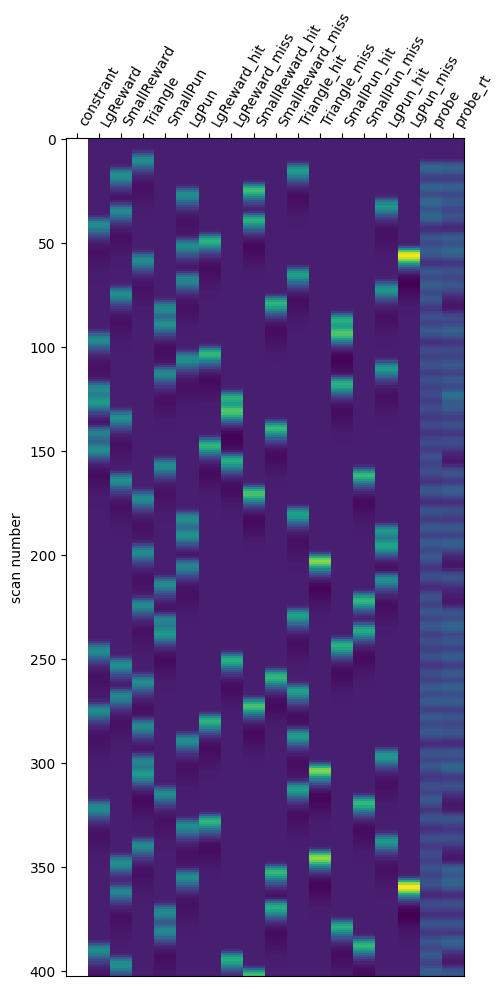

In [11]:
design_events.to_csv(f'{dir_out}/design_events_df.csv', index=False)
plotting.plot_design_matrix(design_matrix_mid)

In [12]:
contrast_labs = {
    # Anticipation
    'LRew-Neut': 'LgReward - Triangle',
    'ARew-Neut': 'LgReward + SmallReward - 2*Triangle',
    'LPun-Neut': 'LgPun - Triangle',
    'APun-Neut': 'LgPun + SmallPun - 2*Triangle',

    # Feedback
    'ARewHit-ARewMiss': 'LgReward_hit + SmallReward_hit - LgReward_miss - SmallReward_miss',
    'LRewHit-LRewMiss': 'LgReward_hit - LgReward_miss',
    'APunHit-APunMiss': 'LgPun_hit + SmallPun_hit - LgPun_miss - SmallPun_miss',
    'LPunHit-LPunMiss': 'LgPun_hit - LgPun_miss',
    'LRewHit-LNeutHit': 'LgReward_hit - Triangle_hit',

    #probe
    'probe-base': 'probe',
    'rt-base': 'probe_rt'

}

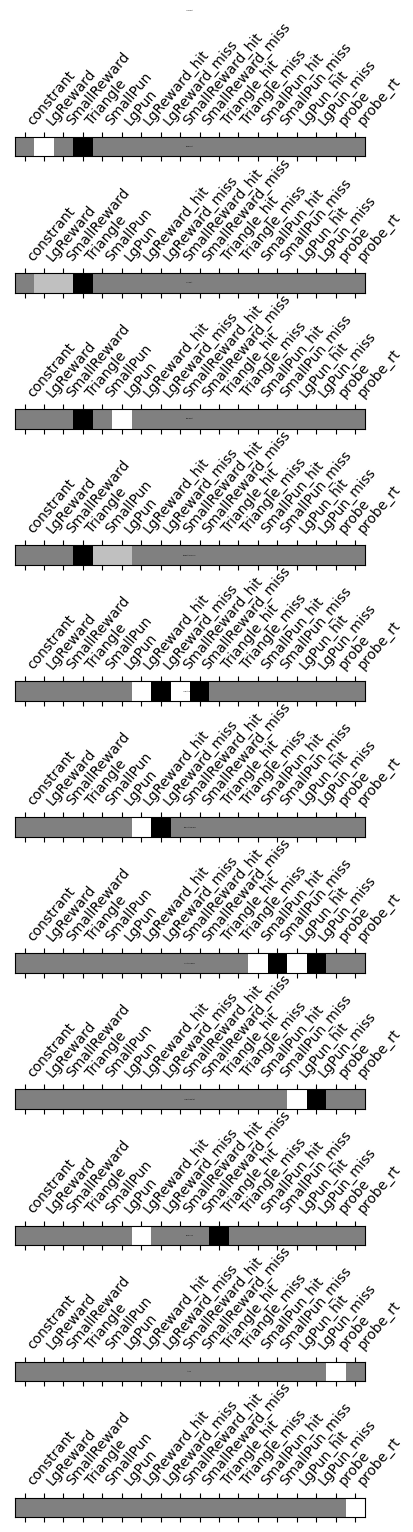

In [14]:
fig, axes = plt.subplots(nrows=len(contrast_labs), ncols=1, figsize=(400, 40))

# Plot each contrast matrix on a separate subplot
for i, (key, values) in enumerate(contrast_labs.items()):
    ax = axes[i]  # Select the appropriate subplot
    plotting.plot_contrast_matrix(values, design_matrix=design_matrix_mid, ax=ax)
    ax.set_title(key, fontsize=.0005)  # Set title for each subplot with smaller font size
plt.subplots_adjust(hspace=6)  # Add space between subplots
plt.show()

In [33]:
vals = design_matrix_mid.columns.values
print(' '.join(vals))

constrant LgReward SmallReward Triangle SmallPun LgPun LgReward_hit LgReward_miss SmallReward_hit SmallReward_miss Triangle_hit Triangle_miss SmallPun_hit SmallPun_miss LgPun_hit LgPun_miss probe probe_rt


In [34]:
for i, (key, values) in enumerate(contrast_labs.items()):
    print(key,'\n',expression_to_contrast_vector(values, design_columns=design_matrix_mid.columns))

LRew-Neut 
 [ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARew-Neut 
 [ 0.  1.  1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
LPun-Neut 
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APun-Neut 
 [ 0.  0.  0. -2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARewHit-ARewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
LRewHit-LRewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APunHit-APunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.]
LPunHit-LPunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
LRewHit-LNeutHit 
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
probe-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
rt-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
